In [1]:
import os
import pickle
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import L1L2

In [2]:
MODEL = "encoder-decoder-t2v"

config = {    
    "TIME_DIMS": 4,
    "ENCODER_SIZE": 16,
    "DENSE_SIZE": 64,
    
    "LR": 0.001,
    "BATCH_SIZE": 32,
    "EPOCHS": 30,
}

In [3]:
RUN_WANDB = False

if(RUN_WANDB):
    import wandb
    from wandb.keras import WandbCallback
    from secrets import WANDB
    wandb.login(key=WANDB)

## **Load Data Function**

In [4]:
def get_data(fold):
    df = pd.read_csv(f'./data/fold_{fold}.csv')
    with open(f'./data/fold_{fold}.npy', mode='rb') as f:
        train_historical_series = np.load(f, allow_pickle=False)
        train_historical_covariates = np.load(f, allow_pickle=False) 
        train_future_covariates = np.load(f, allow_pickle=False)
        train_future_series = np.load(f, allow_pickle=False)
        # val arrays
        val_historical_series = np.load(f, allow_pickle=False)
        val_historical_covariates = np.load(f, allow_pickle=False) 
        val_future_covariates = np.load(f, allow_pickle=False)
        val_future_series = np.load(f, allow_pickle=False)
        # test arrays
        test_historical_series = np.load(f, allow_pickle=False)
        test_historical_covariates = np.load(f, allow_pickle=False) 
        test_future_covariates = np.load(f, allow_pickle=False)
        test_future_series = np.load(f, allow_pickle=False)
        test_dates = np.load(f, allow_pickle=True)
        # data info
        data_features = np.load(f, allow_pickle=False)
    return (
        (train_historical_series,train_historical_covariates,train_future_covariates),
        train_future_series, 
        (val_historical_series,val_historical_covariates,val_future_covariates),
        val_future_series, 
        (test_historical_series,test_historical_covariates,test_future_covariates), 
        test_future_series, 
        test_dates,
        data_features,
        df
    )

X_train, y_train, X_val, y_val, X_test, y_test, test_dates, data_features, df = get_data(2)
print(data_features)
df

[30.73084645 29.04061676]


,datetime,level
0,2005-12-31 12:00:00,60.0
1,2005-12-31 13:00:00,43.0
2,2005-12-31 14:00:00,23.0
3,2005-12-31 15:00:00,1.0
4,2005-12-31 16:00:00,-12.0
...,...,...
52591,2011-12-31 19:00:00,0.0
52592,2011-12-31 20:00:00,-2.0
52593,2011-12-31 21:00:00,2.0
52594,2011-12-31 22:00:00,9.0


In [5]:
X_train[0].shape, X_train[1].shape, X_train[2].shape

((43734, 72, 1), (43734, 72, 4), (43734, 24, 4))

## **Model Functions**

In [6]:
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size=None, **kwargs):
        self.kernel_size = kernel_size
        super(Time2Vec, self).__init__(**kwargs)
    def get_config(self):
        config = super(Time2Vec, self).get_config()
        config.update({"kernel_size": self.kernel_size})
        return config
    def build(self, input_shape):
        # expects the dims of input to be (batch_size, sequence_length, time_dims)
        # these parameters are for the linear space embedding, not periodic
        # converts time dims to just one, gives one linear time embedding per step in sequence
        self.w = self.add_weight(name='w',
                                 shape=(input_shape[-1], 1),
                                 initializer='uniform',
                                 trainable=True)
        self.p = self.add_weight(name='p',
                                 shape=(input_shape[-2], 1),
                                 initializer='uniform',
                                 trainable=True)
        # These variables are used to be periodic in nature
        # converts the time dim to a vector of length kernel size - 1, adding these together we get vector length k for each time step
        self.W = self.add_weight(name='W',
                                 shape=(input_shape[-1], self.kernel_size-1),
                                 initializer='uniform',
                                 trainable=True)
        self.P = self.add_weight(name='P',
                                 shape=(input_shape[-2], self.kernel_size-1),
                                 initializer='uniform',
                                 trainable=True)
        super(Time2Vec, self).build(input_shape)
    def call(self, inputs):
        original = K.dot(inputs, self.w) + self.p
        sin_trans = K.sin(K.dot(inputs, self.W) + self.P)
        return K.concatenate([original, sin_trans], axis=-1) 

def simple_encoder_decoder(historical_series_shape, historical_covariates_shape, future_covariates_shape):
    historical_series = tf.keras.layers.Input(shape=historical_series_shape)
    historical_covariates = tf.keras.layers.Input(shape=historical_covariates_shape)
    future_covariates = tf.keras.layers.Input(shape=future_covariates_shape)
    
    historicals = Time2Vec(config["TIME_DIMS"])(historical_series)
#     historicals = tf.keras.layers.Concatenate()([encoded_series, historical_covariates])
    embeddings = tf.keras.layers.LSTM(config["ENCODER_SIZE"], 
                                      return_sequences=True, 
                                      return_state=False, 
                                      recurrent_initializer='glorot_uniform', 
                                      activity_regularizer=L1L2(l1=0.000001, l2=0.000001))(historicals)
    embeddings = tf.keras.layers.LSTM(config["ENCODER_SIZE"],
                                      return_sequences=False,
                                      return_state=False,
                                      recurrent_initializer='glorot_uniform', 
                                      activity_regularizer=L1L2(l1=0.000001, l2=0.000001))(embeddings)
    
    decoder = tf.keras.layers.Dense(config["DENSE_SIZE"])(embeddings)
    decoder = tf.keras.layers.Dense(future_covariates_shape[0])(decoder)
    decoder = tf.expand_dims(decoder, -1)
    
    stacked_decoder = decoder
#     stacked_decoder = tf.keras.layers.Concatenate()([decoder, future_covariates])
    
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(stacked_decoder)
    outputs = tf.squeeze(outputs, axis=-1)
    model = tf.keras.models.Model(inputs=[historical_series, historical_covariates, future_covariates], outputs=outputs)
    model.compile(loss="mse", metrics=["mae"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["LR"]))
    return model

model = simple_encoder_decoder(X_train[0].shape[1:], X_train[1].shape[1:], X_train[2].shape[1:])
model.summary()

Metal device set to: Apple M1 Pro


2022-12-14 16:13:53.059493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 16:13:53.059812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 1)]      0           []                               
                                                                                                  
 time2_vec (Time2Vec)           (None, 72, 4)        292         ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 72, 16)       1344        ['time2_vec[0][0]']              
                                                                                                  
 lstm_1 (LSTM)                  (None, 16)           2112        ['lstm[0][0]']                   
                                                                                              

In [7]:
reducer = tf.keras.callbacks.ReduceLROnPlateau(monior='val_loss', factor=0.1, patience=2, mode='min', cooldown=1)
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min', restore_best_weights=True)
if(RUN_WANDB):
    callbacks = [reducer, stopper, WandbCallback()]
else:
    callbacks = [reducer, stopper]

model.fit(X_train, y_train,
          batch_size=config["BATCH_SIZE"],
          epochs=config["EPOCHS"], 
          callbacks=callbacks,
          validation_data=(X_val, y_val),
          validation_batch_size=config["BATCH_SIZE"],
          shuffle=True)

Epoch 1/30


2022-12-14 16:13:53.768279: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-14 16:13:55.326237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:13:55.606183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:13:55.777762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:13:56.208874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:13:56.525012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1367/1367 [==============================] - ETA: 0s - loss: 0.2804 - mae: 0.3727

2022-12-14 16:15:07.213544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:15:07.311657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:15:07.442956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1367/1367 [==============================] - 81s 57ms/step - loss: 0.2804 - mae: 0.3727 - val_loss: 0.0698 - val_mae: 0.1962 - lr: 0.0010
Epoch 2/30
1367/1367 [==============================] - 75s 55ms/step - loss: 0.0936 - mae: 0.2208 - val_loss: 0.0612 - val_mae: 0.1808 - lr: 0.0010
Epoch 3/30
1367/1367 [==============================] - 74s 54ms/step - loss: 0.0889 - mae: 0.2139 - val_loss: 0.0625 - val_mae: 0.1836 - lr: 0.0010
Epoch 4/30
1367/1367 [==============================] - 69s 50ms/step - loss: 0.0861 - mae: 0.2096 - val_loss: 0.0618 - val_mae: 0.1826 - lr: 0.0010
Epoch 5/30
1367/1367 [==============================] - 69s 50ms/step - loss: 0.0818 - mae: 0.2024 - val_loss: 0.0558 - val_mae: 0.1701 - lr: 1.0000e-04
Epoch 6/30
1367/1367 [==============================] - 69s 50ms/step - loss: 0.0814 - mae: 0.2017 - val_loss: 0.0557 - val_mae: 0.1698 - lr: 1.0000e-04
Epoch 7/30
1367/1367 [==============================] - 70s 51ms/step - loss: 0.0812 - mae: 0.2014 - val_loss

In [8]:
model.evaluate(X_test, y_test)

271/271 [==============================] - 7s 27ms/step - loss: 0.0966 - mae: 0.2084


[0.09663622081279755, 0.20843693614006042]

In [9]:
predictions = model.predict(X_test)
predictions = (predictions * data_features[1]) + data_features[0]
actuals = (y_test * data_features[1]) + data_features[0]
predictions

2022-12-14 16:34:27.781407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:34:27.858635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:34:27.979542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 7s 23ms/step


array([[26.547935 , 32.09235  , 36.636173 , ..., 25.712482 , 30.60103  ,
        33.91458  ],
       [33.054672 , 40.040916 , 45.56031  , ..., 31.22228  , 34.842896 ,
        37.773514 ],
       [40.27483  , 47.865234 , 53.54908  , ..., 34.879143 , 37.74749  ,
        40.84002  ],
       ...,
       [28.55518  , 15.359157 ,  7.463972 , ..., 60.540752 , 60.85241  ,
        52.86841  ],
       [16.10894  ,  8.158495 ,  7.8741283, ..., 60.300488 , 52.39501  ,
        39.54756  ],
       [ 9.844748 ,  9.366932 , 16.761297 , ..., 52.36672  , 39.11532  ,
        25.155952 ]], dtype=float32)

In [10]:
predictions.shape, actuals.shape

((8670, 24), (8670, 24))

8.825443927517838


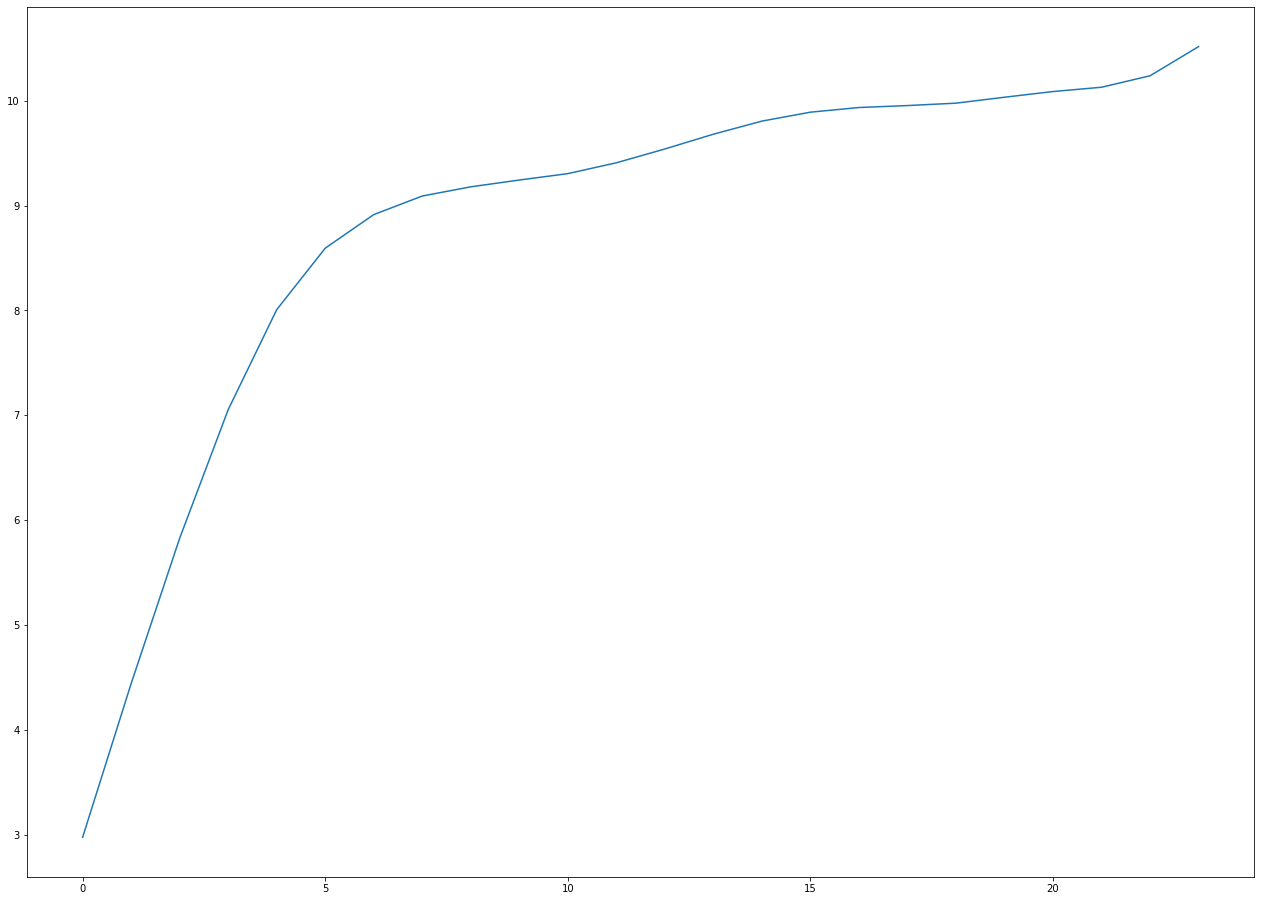

In [12]:
errors = np.sqrt(np.mean(np.square(predictions - actuals), axis=0))
print(np.mean(errors))
_, ax = plt.subplots(figsize=(22,16))
ax.plot(np.arange(len(errors)), errors);